### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os, gc; from os.path import exists
os.chdir('/vortexfs1/home/anthony.meza/CTWPC/scripts')
main_dir = "/vortexfs1/home/anthony.meza/CTWPC"
plotsdir = lambda x="": main_dir + "/plots/" + x
GLORYS_dir = lambda x="": main_dir + "/GLORYS_data" + x
GLORYS_data_dir = lambda x="": main_dir + "/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": main_dir + "/ERA5_data/" + x

In [2]:
from help_funcs import * 
import gc, os, importlib, copy, pickle
from os.path import exists
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal.windows import tukey
from scipy.fft import fft2, ifft2, fftfreq, fftshift, fft, rfft2, irfft2, ifftshift
from scipy.signal import butter, filtfilt
from datetime import datetime

#bandpass functions
def butter_bandpass(lowcut, highcut, fs, order=2):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y
bandpassed = lambda x: butter_bandpass_filter(x, 1/120, 1/20, 1, 4)

### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [1]:
coast_vars = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars.nc")).sel(depth = slice(0, 22)).compute()
coast_vars["time"] = coast_vars.indexes['time'].normalize()
hovmoller_ds = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Path.nc")).compute()

coast_vars = coast_vars.convert_calendar('noleap')

climatology = coast_vars.groupby("time.dayofyear").mean("time")
smooth_climatology = smooth_daily_climatology(climatology)

NameError: name 'xr' is not defined

In [6]:
#compute anomalies references to a daily climatology
anomalies = coast_vars.groupby("time.dayofyear") - smooth_climatology

#fix indices
reindex_datetimes = [datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S') for date in coast_vars.time.values]
coast_vars["time"] = reindex_datetimes; anomalies["time"] = reindex_datetimes

#transpose data 
anomalies = anomalies.transpose("time", "distance", "depth").drop("dayofyear").compute()

anomalies.to_netcdf(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

In [10]:
anomalies_filtered = copy.deepcopy(anomalies)
for var in ["zos", "thetao"]:
    anomalies_filtered[var].values = np.apply_along_axis(func1d=bandpassed, 
                                                          axis=0, 
                                                          arr=anomalies[var].values)
#interpolate over and make data equally spaced
dx = 10 
interp_distances = np.arange(0, int(anomalies.distance.max()), dx)
anomalies_filtered = anomalies_filtered.interpolate_na(dim = "distance", method = "linear")
anomalies_filtered = anomalies_filtered.interp(distance = interp_distances, method = "linear")

anomalies_filtered.to_netcdf(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_bandpass.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

In [11]:
#compute average temperature of the mixed layer 
coords_pth = "/vortexfs1/share/cdx/hseo/Data/MERCATOR/GLO-MFC_001_030_coordinates.nc"
nz = len(anomalies_filtered.depth)
z = anomalies_filtered.depth.values
coords = xr.open_dataset(coords_pth).sel(depth = z, method = "nearest")

#get cell depths
dz = 0.0 * anomalies_filtered.thetao.isel(time = 0)
dz = dz.rename("dz")
for iz in range(nz):
    dz.values[:, iz] = coords.e3t.values[iz]
H = dz.sum("depth"); H = H.rename("H")
#depth average over the mixed layer
mx_temps = (anomalies_filtered.thetao * dz).sum("depth") / H

### Apply a wave number and frequency filter 

In [14]:
anomalies_filtered_kandf = copy.deepcopy(anomalies_filtered.drop("thetao").drop("depth"))

#remove negative wave numbers from zos 
filtered_vals, fft_vals = filter_negative_wavenumbers(anomalies_filtered.zos.values)
anomalies_filtered_kandf.zos.values = filtered_vals

#remove negative wave numbers from mxlayertemps
anomalies_filtered_kandf["thetao"] = mx_temps
filtered_vals, fft_vals = filter_negative_wavenumbers(mx_temps.values)
anomalies_filtered_kandf.thetao.values =  filtered_vals

#save the filtered data
anomalies_filtered_kandf.to_netcdf(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_SpaceTimeFiltered.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)


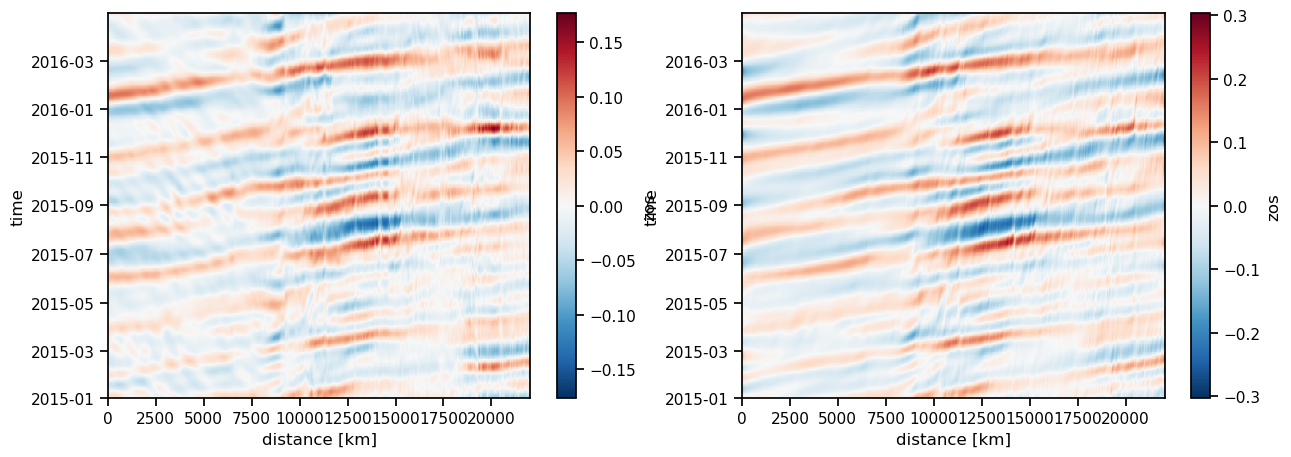

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
anomalies_filtered.zos.sel(time = slice("2015", "04-2016")).plot(ax = ax[0])
anomalies_filtered_kandf.zos.sel(time = slice("2015", "04-2016")).plot(ax = ax[1])

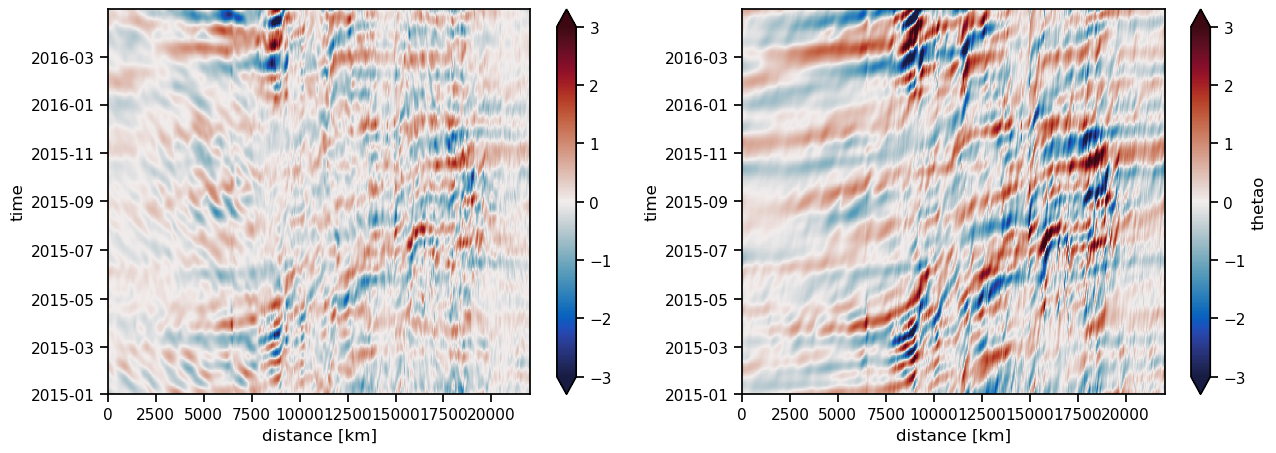

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
mx_temps.sel(time = slice("2015", "04-2016")).plot(ax = ax[0], vmin = -3, vmax = 3, cmap = cm.balance)
anomalies_filtered_kandf.thetao.sel(time = slice("2015", "04-2016")).plot(ax = ax[1], vmin = -3, vmax = 3, cmap = cm.balance)